In [1]:
import scportrait
from scportrait.pipeline._utils.segmentation import segment_global_threshold
from scportrait.processing.images import downsample_img_padding
from skimage.filters import gaussian
from skimage.transform import resize
from skimage.measure import label

import spatialdata
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
import matplotlib as mpl

color_list_red = [ '#FFFFFF','#B3262A']
custom_cmap_red = mpl.colors.LinearSegmentedColormap.from_list('custom_gradient', color_list_red)


/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
sdata_path = "../processed_data/scportrait_project_codex_region1/scportrait.sdata"
sdata = spatialdata.read_zarr(sdata_path)

version mismatch: detected: RasterFormatV02, requested: FormatV04


## Generate shapes corresponding to Germinal Centers

Using the CODEX marker CD21 as an indicator of germinal centers.

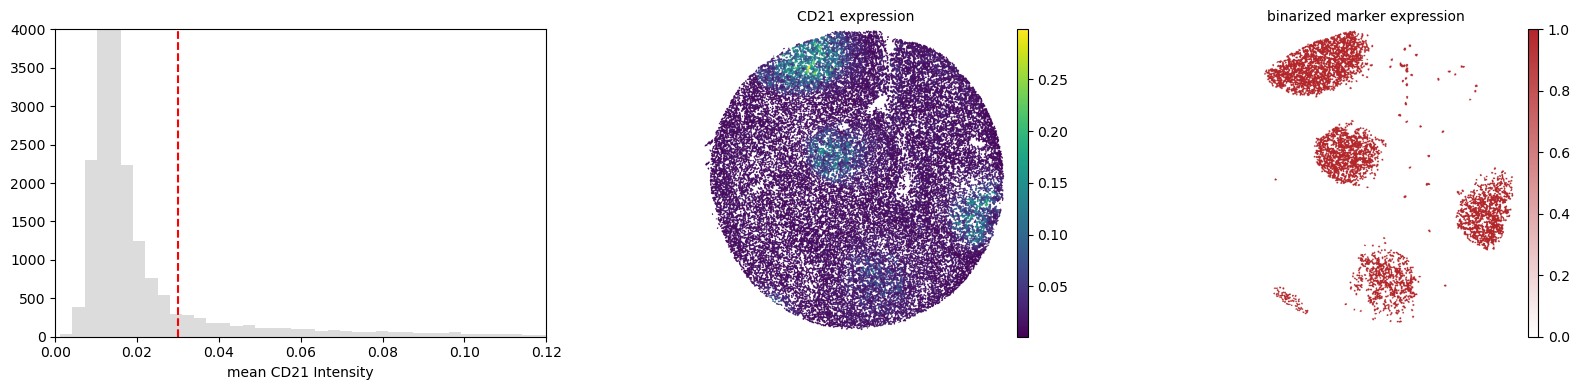

  0%|          | 0/3068 [00:00<?, ?it/s]

Performing image padding to ensure that image is compatible with selected downsample kernel size of 5.
Downsampling image by a factor of 5x5
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


In [3]:
marker = "CD21"
threshold = 0.03

fig, axs = plt.subplots(1, 3, figsize = (16,4))

sdata['CellFeaturizer_all_nucleus'].obs["Tcell_region"] = sdata['CellFeaturizer_all_nucleus'][:, f"{marker}_mean_nucleus"].X > threshold

axs[0].hist(sdata['CellFeaturizer_all_nucleus'][:, f"{marker}_mean_nucleus"].X.ravel(), bins = 100, color = "gainsboro")
axs[0].set_xlabel(f"mean {marker} Intensity")
axs[0].set_xlim(0, 0.12)
axs[0].set_ylim(0, 4000)
axs[0].vlines(threshold, 0, 4000, color = "red", linestyle = "--")

scportrait.pl.sdata.plot_labels(sdata, 
                                label_layer="seg_all_nucleus",
                                color = f"{marker}_mean_nucleus",
                                #cmap = custom_cmap_red,
                                show_fig=False,
                                vectorized = False, 
                                ax = axs[1],
                                title = f"{marker} expression", 
                                title_fontsize=10)

scportrait.pl.sdata.plot_labels(sdata, 
                                label_layer="seg_all_nucleus",
                                color = "Tcell_region",
                                cmap = custom_cmap_red,
                                show_fig=False,
                                ax = axs[2], 
                                title = "binarized marker expression", 
                                title_fontsize=10)
fig.tight_layout()
plt.show()

# use CD21+ cells to generate a region annotation for areas with a strong accumulation of CD21+ cells
select_ids = set(sdata['CellFeaturizer_all_nucleus'].obs[sdata['CellFeaturizer_all_nucleus'].obs["Tcell_region"]].scportrait_cell_id.astype(int))
seg_mask = sdata["seg_all_nucleus"].scale0.image.data.compute()

for id in tqdm(select_ids):
    seg_mask = np.where(seg_mask == id, True, seg_mask)

seg_mask = np.where(seg_mask != True, 0, seg_mask)

n_px = 5 # number of pixels that will be binned together
downsampled_images = downsample_img_padding(seg_mask[np.newaxis, ...] , n_px)

# additional percentile normalization  + gaussian blur to improve thresholding
blurred_images = gaussian(downsampled_images, sigma=12)

small_mask = segment_global_threshold(blurred_images[0], dilation = 1, peak_footprint=19)
mask = resize(small_mask,seg_mask.shape)
mask = mask > 0

mask = label(mask)
sdata["GC_regions"] = spatialdata.models.Labels2DModel.parse(mask)

In [4]:
# write generated regions out to disk
scportrait.tl.sdata.add_element_sdata(sdata, sdata["GC_regions"], element_name="GC_regions")

## Generate shapes corresponding to T-cell rich areas

Using the CODEX marker CD3 as an indicator for T-cells.

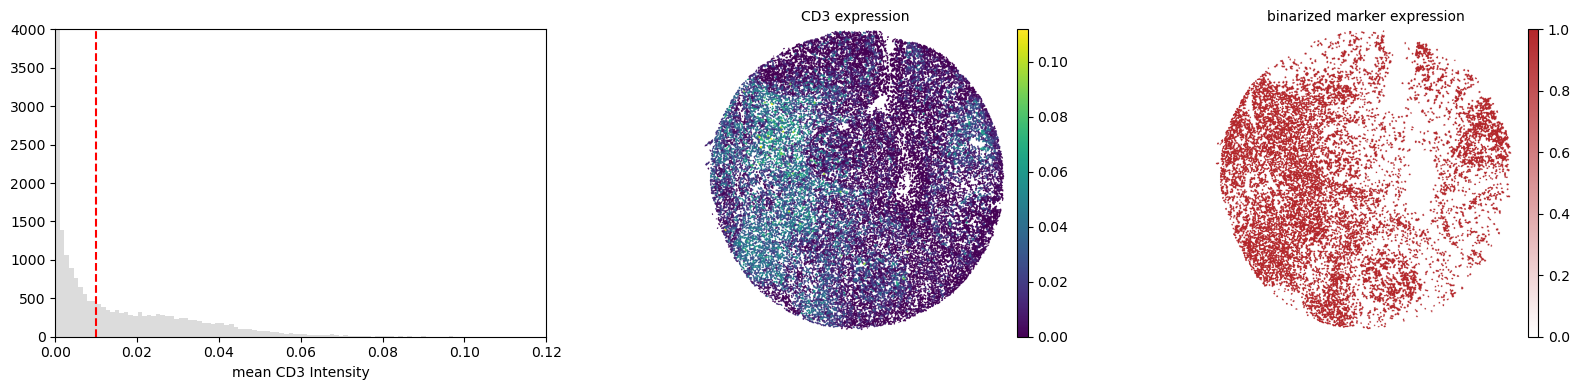

  0%|          | 0/9286 [00:00<?, ?it/s]

Performing image padding to ensure that image is compatible with selected downsample kernel size of 5.
Downsampling image by a factor of 5x5
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


In [5]:
marker = "CD3"
threshold = 0.01

fig, axs = plt.subplots(1, 3, figsize = (16,4))

sdata['CellFeaturizer_all_nucleus'].obs["Tcell_region"] = sdata['CellFeaturizer_all_nucleus'][:, f"{marker}_mean_nucleus"].X > threshold

axs[0].hist(sdata['CellFeaturizer_all_nucleus'][:, f"{marker}_mean_nucleus"].X.ravel(), bins = 100, color = "gainsboro")
axs[0].set_xlabel(f"mean {marker} Intensity")
axs[0].set_xlim(0, 0.12)
axs[0].set_ylim(0, 4000)
axs[0].vlines(threshold, 0, 4000, color = "red", linestyle = "--")

scportrait.pl.sdata.plot_labels(sdata, 
                                label_layer="seg_all_nucleus",
                                color = f"{marker}_mean_nucleus",
                                #cmap = custom_cmap_red,
                                show_fig=False,
                                vectorized = False, 
                                ax = axs[1],
                                title = f"{marker} expression", 
                                title_fontsize=10)

scportrait.pl.sdata.plot_labels(sdata, 
                                label_layer="seg_all_nucleus",
                                color = "Tcell_region",
                                cmap = custom_cmap_red,
                                show_fig=False,
                                ax = axs[2], 
                                title = "binarized marker expression", 
                                title_fontsize=10)
fig.tight_layout()
plt.show()

# use CD21+ cells to generate a region annotation for areas with a strong accumulation of CD21+ cells
select_ids = set(sdata['CellFeaturizer_all_nucleus'].obs[sdata['CellFeaturizer_all_nucleus'].obs["Tcell_region"]].scportrait_cell_id.astype(int))
seg_mask = sdata["seg_all_nucleus"].scale0.image.data.compute()

for id in tqdm(select_ids):
    seg_mask = np.where(seg_mask == id, True, seg_mask)

seg_mask = np.where(seg_mask != True, 0, seg_mask)

n_px = 5 # number of pixels that will be binned together
downsampled_images = downsample_img_padding(seg_mask[np.newaxis, ...] , n_px)

# additional percentile normalization  + gaussian blur to improve thresholding
blurred_images = gaussian(downsampled_images, sigma=12)

small_mask = segment_global_threshold(blurred_images[0], dilation = 1, peak_footprint=19)
mask = resize(small_mask,seg_mask.shape)
mask = mask > 0

mask = label(mask)
sdata["Tcell_rich_regions"] = spatialdata.models.Labels2DModel.parse(mask)

In [6]:
# write generated regions out to disk
scportrait.tl.sdata.add_element_sdata(sdata, sdata["Tcell_rich_regions"], element_name="Tcell_rich_regions")